# NEON + other input data for hi-res data cube generation for AGB modelling  
Paul Montesano  

This notebook performs analyses that tell us:  
1. which subtiles to run  
2. the subtiles names and extents  
3. where to return results  

 - NEON lidar + hyperspectral + hyperspectral derivates returned by NEON subtile for a given site for all subtiles that have all years' worth of data
 - Tiled data are mosaicked into VRTs
 - LCMS (yearly LCLUC + epochal change layers) are mosaicked into VRTs
 - All NEON and LCMS are warped to NEON extent and res using nearest neighbor
 - Each warped file is written as a clipped geotiff by site, year to a specific subtile subdirectory under a user-defined output directory 
 - Coarse data (MERRA2) are returned as a time-series table representing variables across time for a single lat/lon


In [6]:
import os, errno
import sys
sys.path.append('/home/pmontesa/code/pygeotools')
from pygeotools.lib import iolib, malib, geolib, filtlib, warplib

sys.path.append('/home/pmontesa/code/geoscitools')
import NEONlib
import footprintlib

import glob
from glob import glob
import rasterio
from rasterio.mask import mask
from rasterio.plot import show

from osgeo import gdal 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import geopandas as gpd
import pandas as pd
import numpy as np

import contextily as ctx
import shapely
from shapely.geometry import box

import os, tempfile

def symlink(target, link_name, overwrite=False):
    '''
    Create a symbolic link named link_name pointing to target.
    If link_name exists then FileExistsError is raised, unless overwrite=True.
    When trying to overwrite a directory, IsADirectoryError is raised.
    '''

    if not overwrite:
        os.symlink(target, link_name)
        return

    # os.replace() may fail if files are on different filesystems
    link_dir = os.path.dirname(link_name)

    # Create link to target with temporary filename
    while True:
        temp_link_name = tempfile.mktemp(dir=link_dir)

        # os.* functions mimic as closely as possible system functions
        # The POSIX symlink() returns EEXIST if link_name already exists
        # https://pubs.opengroup.org/onlinepubs/9699919799/functions/symlink.html
        try:
            os.symlink(target, temp_link_name)
            break
        except FileExistsError:
            pass

    # Replace link_name with temp_link_name
    try:
        # Pre-empt os.replace on a directory with a nicer message
        if not os.path.islink(link_name) and os.path.isdir(link_name):
            raise IsADirectoryError(f"Cannot symlink over existing directory: '{link_name}'")
        os.replace(temp_link_name, link_name)
    except:
        if os.path.islink(temp_link_name):
            os.remove(temp_link_name)
        raise

In [2]:
def get_ndv(r_fn):
    with rasterio.open(r_fn) as src:
        return src.profile['nodata']

### Notes on data layers

__NEON: LiDAR : assembled here__

__NEON: Hyperspectral indices: assembled using `Wrangler Process` and read in here__  
Custom veg indices list:
https://docs.google.com/spreadsheets/d/1BQ3hY6CS93BHPzdscjHDEbswhTjP0M5mxM8JrhGkbYs/edit#gid=0

__Landsat: Landsat Change Monitoring System (LCMS) layers: assembled here__  
https://data.fs.usda.gov/geodata/rastergateway/LCMS/index.php

__SSURGO__  
soilDB from Beaudette et al:  
https://github.com/ncss-tech/soilDB/  
tutorial:  
https://ncss-tech.github.io/AQP/soilDB/WCS-demonstration-01.html  

other links:  
https://planetarycomputer.microsoft.com/dataset/gnatsgo-rasters  
https://casoilresource.lawr.ucdavis.edu/soil-properties/download.php


__Climate data: MERRA2 daily temp, precip__  

__Drought data: Palmer drought severity index (PDSI)__  
/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/data/NEON_gridmetDROUGHT_parameters  


In [3]:
NEON_SITE_YEARS_LIST_DICTIONARY = {'MLBS': [int(i) for i in ['2015','2017','2018','2021']], 
                                   'SERC': ['2016','2017','2019','2021','2022']
                                  }

NEON_HYPERSPECTRAL_PRODUCT_DICTIONARY = {
    'SOURCE' : 'Airborne_Hyperspectral',
    'TYPE' : 'Spectrometer',
    'VegIndices': 'DP3.30026.001',
    'WaterIndices': 'DP3.30019.001',
    'FPAR': 'DP3.30014.001',
    'LAI': 'DP3.30012.001',
    'Albedo': 'DP3.30011.001',
    'Reflectance': 'DP3.30006.001',     
}
NEON_LIDAR_PRODUCT_DICTIONARY = {
    'SOURCE' : 'Airborne_Lidar',
    'TYPE' : 'DiscreteLidar',
    'ClassifiedPointCloud': 'DP1.30003.001',
    'AspectGtif': 'DP3.30025.001',
    'SlopeGtif': 'DP3.30025.001',
    'CHMGtif': 'DP3.30024.001',
    'DSMGtif': 'DP3.30024.001', 
    'DTMGtif': 'DP3.30024.001', 
    'FSDGtif': 'DP3.30024.001', #CHM & RUG from Glenn
}

In [10]:
# Footprints of NEON tiles across all sites (run for LiDAR, should hold for hyperspectral - untested)
neon_footprints_fn = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/footprints/footprints_DSM.gpkg'
neon_footprints_gdf = gpd.read_file(neon_footprints_fn)

# Get 'year' field from 'file' field
neon_footprints_gdf['year'] = neon_footprints_gdf['file'].str.split('_', expand=True)[0]
# Get 'site' field from 'file' field
neon_footprints_gdf['site'] = neon_footprints_gdf['file'].str.split('_', expand=True)[3]
# Get NEON tile identifier needed to find corresponding hyperspectral h5 files (non spatial)
neon_footprints_gdf['tile_id'] = neon_footprints_gdf['file'].str.split('_', expand=True)[5] + '_' + neon_footprints_gdf['file'].str.split('_', expand=True)[6]
neon_footprints_gdf.head()

,footprint_name,path,file,area_km2,area_ha,geometry,year,site,tile_id
0,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2017_NEON_D16_ABBY_DP3_547000_5062000_DSM.tif,1.0,100.0,"POLYGON ((-122.38332 45.70989, -122.38322 45.7...",2017,ABBY,547000_5062000
1,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2017_NEON_D16_ABBY_DP3_556000_5063000_DSM.tif,1.0,100.0,"POLYGON ((-122.26758 45.71821, -122.26746 45.7...",2017,ABBY,556000_5063000
2,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2017_NEON_D16_ABBY_DP3_548000_5065000_DSM.tif,1.0,100.0,"POLYGON ((-122.37017 45.73682, -122.37007 45.7...",2017,ABBY,548000_5065000
3,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2017_NEON_D16_ABBY_DP3_550000_5072000_DSM.tif,1.0,100.0,"POLYGON ((-122.34372 45.79968, -122.34362 45.8...",2017,ABBY,550000_5072000
4,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2017_NEON_D16_ABBY_DP3_558000_5073000_DSM.tif,1.0,100.0,"POLYGON ((-122.24067 45.80804, -122.24054 45.8...",2017,ABBY,558000_5073000


In [11]:
neon_footprints_gdf.to_file('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/footprints/footprints_NEON_DSM.gpkg')

In [5]:
# Read NEON centroids
NEON_SITES_fn = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/data/neon_sites_centroids.csv'
neon_sites_df = pd.read_csv(NEON_SITES_fn)
neon_sites_df.head()

,site,site_full_name,lat,lon,field_geoid,field_utm_y,field_utm_x,UTM zone,hemisphere,LLy_1kmbbox,LLx_1kmbbox,URy_1kmbbox,URx_1kmbbox
0,ABBY,Abby Road NEON,45.76244,-122.3300,WGS84,5067870,552075.5,10,N,5067370,551575.5,5068370,552575.5
1,BART,Bartlett Experimental Forest NEON,44.06389,-71.2874,WGS84,4881512,316812.2,19,N,4881012,316312.2,4882012,317312.2
2,BONA,Caribou-Poker Creeks Research Watershed NEON,65.15401,-147.5030,WGS84,7225713,476436.7,6,N,7225213,475936.7,7226213,476936.7
3,CLBJ,Lyndon B. Johnson National Grassland NEON,33.40123,-97.5700,WGS84,3696682,632982.2,14,N,3696182,632482.2,3697182,633482.2
4,DEJU,Delta Junction NEON,63.88112,-145.7510,WGS84,7084367,561330.1,6,N,7083867,560830.1,7084867,561830.1


## Set SITE Dictionary List

In [6]:
# A list of dictionaries with the site infor for each site assembled below
SITE_DICT_LIST = []
# Initialize empty dictionary
SITE_DICT = {
    'SITE': str,
    'SITE_SIZE_m': float,
    'YEARS_LIST': list,
    'site_gdf': '',
    }

# SITE selection

In [7]:
SITE_SIZE_m = 1000 # length & width in meters of a site
SITE = 'MLBS'
YEARS_LIST = NEON_SITE_YEARS_LIST_DICTIONARY[SITE]
REGION = '*' #'D07' # this not acutally needed

## Update SITE Dictionary LIST

In [8]:
SITE_DICT = {
    'SUBTILE': '',
    'SITE_SIZE_m': SITE_SIZE_m,
    'YEARS_LIST': YEARS_LIST,
    'site_gdf': '',
    }

### Working Dirs

In [9]:
MAINDIR = '/explore/nobackup/projects/ilab/data/AGB'
#SUBDIR = os.path.join(MAINDIR, 'test','beta_pmm')

# Wrangler wrote out all 4 reflectance tifs for MLBS years here:
MAINDIR_REFL = '/explore/nobackup/projects/ilab/projects/AGB'

OUTDIR = os.path.join(MAINDIR, 'output', SITE, 'subtiles')
!mkdir -p $OUTDIR

## SITE based on NEON centroid

In [10]:
# Subset to site, get a geodataframe
site_df = neon_sites_df[neon_sites_df.site == SITE]
site_gdf = gpd.GeoDataFrame(site_df, geometry=gpd.points_from_xy(site_df.lon, site_df.lat))
site_gdf

,site,site_full_name,lat,lon,field_geoid,field_utm_y,field_utm_x,UTM zone,hemisphere,LLy_1kmbbox,LLx_1kmbbox,URy_1kmbbox,URx_1kmbbox,geometry
10,MLBS,Mountain Lake Biological Station NEON,37.37831,-80.5248,WGS84,4136943,542067.6,17,N,4136443,541567.6,4137443,542567.6,POINT (-80.52480 37.37831)


## SITE based on existing 1km NEON subtiles - using footprint of NEON subtiles
### Find set of NEON lidar subtiles that have lidar for all years
get list of NEON subtiles that overlap ALL lidar collects (the intersection)

In [11]:
footprint_NEON_lidar_fn = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/footprints/footprints_DSM.gpkg'
footprint_NEON_lidar = gpd.read_file(footprint_NEON_lidar_fn)
footprint_NEON_lidar['year'] = footprint_NEON_lidar['file'].str.split('_', expand=True)[0].astype(str)#.astype(int)
footprint_NEON_lidar['site'] = footprint_NEON_lidar['file'].str.split('_', expand=True)[3]
footprint_NEON_lidar['subtile'] = footprint_NEON_lidar['file'].str.split('_', expand=True)[5] + '_' + footprint_NEON_lidar['file'].str.split('_', expand=True)[6]

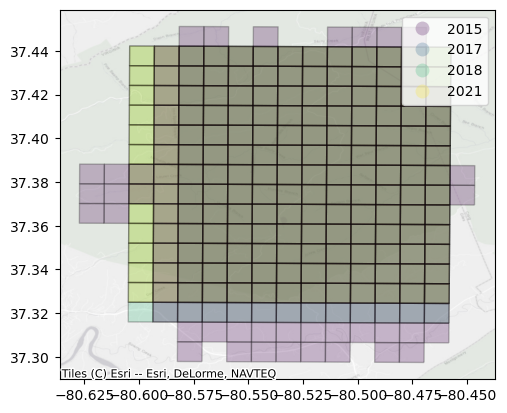

In [12]:
#ax = site_gdf.plot()
ax = footprint_NEON_lidar[footprint_NEON_lidar['site'] == SITE].to_crs(4326).plot(alpha=0.25, column='year', cmap='viridis', legend=True, ec='black')
ax = ctx.add_basemap(ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas)

In [13]:
footprint_NEON_lidar.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27322 entries, 0 to 27321
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   footprint_name  0 non-null      object  
 1   path            27322 non-null  object  
 2   file            27322 non-null  object  
 3   area_km2        27322 non-null  float64 
 4   area_ha         27322 non-null  float64 
 5   geometry        27322 non-null  geometry
 6   year            27322 non-null  object  
 7   site            27322 non-null  object  
 8   subtile         27322 non-null  object  
dtypes: float64(2), geometry(1), object(6)
memory usage: 1.9+ MB


In [68]:
m = footprint_NEON_lidar[(footprint_NEON_lidar['site'] == SITE)].explore(column='year', cmap='viridis', legend=True, 
                                                                       style_kwds=dict(color="white",weight=1, opacity=0.1, fillOpacity=.5))
m

##### Show the # subtiles for each lidar year at the site

In [15]:
df_count_subtiles = footprint_NEON_lidar.groupby(['year', 'site']).size().reset_index(name='count_subtiles')
df_count_subtiles[df_count_subtiles.site == SITE]

,year,site,count_subtiles
9,2015,MLBS,202
36,2017,MLBS,143
58,2018,MLBS,182
103,2021,MLBS,169


##### Summarize the count of lidar years for site

In [16]:
df = df_count_subtiles.groupby(['site']).size().reset_index(name='count_lidaryears')#[footprint_NEON_lidar.site == SITE]
num_lidaryears = df[df.site == SITE].count_lidaryears.to_list()[0]
print(f'{num_lidaryears} years of lidar at {SITE}')

4 years of lidar at MLBS


##### Summarize by subtile and find count_subtiles = count_lidaryears

In [17]:
footprint_NEON_lidar_SITE = footprint_NEON_lidar[footprint_NEON_lidar.site == SITE]
df_count_subtiles = footprint_NEON_lidar_SITE.groupby(['subtile', 'site']).size().reset_index(name='count_subtiles')
df_subtile_smry_alllidaryears = df_count_subtiles[df_count_subtiles.count_subtiles == num_lidaryears]
num_subtiles_with_max_lidaryears = len(df_subtile_smry_alllidaryears)
print(f'{num_subtiles_with_max_lidaryears} subtiles that have lidar for all years at {SITE}')

141 subtiles that have lidar for all years at MLBS


In [18]:
df_subtile_smry_alllidaryears.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 37 to 211
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subtile         141 non-null    object
 1   site            141 non-null    object
 2   count_subtiles  141 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 4.4+ KB


##### Get the SITE footprint for subtiles with ALL lidar years - this area is available for the max time series analysis
these are the tiles you want to LOOP over and output data cubes

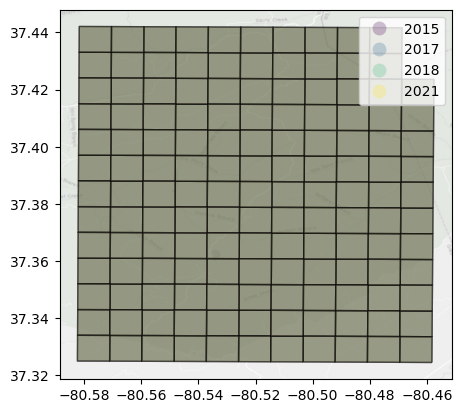

In [19]:
footprint_NEON_lidar_SITE_joined_alllidaryears = pd.merge(footprint_NEON_lidar_SITE, df_subtile_smry_alllidaryears, on=['subtile', 'subtile'], how='inner')
ax = footprint_NEON_lidar_SITE_joined_alllidaryears.to_crs(4326).plot(alpha=0.25, column='year', cmap='viridis', legend=True, ec='black')
ax = ctx.add_basemap(ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas, attribution=' ')

In [69]:
m = footprint_NEON_lidar_SITE_joined_alllidaryears.boundary.explore(m=m, color='black')
m

In [21]:
footprint_NEON_lidar_SITE_joined_alllidaryears.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 564 entries, 0 to 563
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   footprint_name  0 non-null      object  
 1   path            564 non-null    object  
 2   file            564 non-null    object  
 3   area_km2        564 non-null    float64 
 4   area_ha         564 non-null    float64 
 5   geometry        564 non-null    geometry
 6   year            564 non-null    object  
 7   site_x          564 non-null    object  
 8   subtile         564 non-null    object  
 9   site_y          564 non-null    object  
 10  count_subtiles  564 non-null    int64   
dtypes: float64(2), geometry(1), int64(1), object(7)
memory usage: 52.9+ KB


### Make list of NEON subtiles

Need to make `footprint_NEON_lidar_SITE_joined_alllidaryears` have same fields of `site_gdf`

In [22]:
NEON_TILE_ID_LIST_1km_subtiles_site = df_subtile_smry_alllidaryears.subtile.to_list()
print(len(NEON_TILE_ID_LIST_1km_subtiles_site))

with open("/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/data/MLBS_subtile_list.txt", "w") as output:
    for row in NEON_TILE_ID_LIST_1km_subtiles_site:
        output.write(str(row) + '\n')

141


In [23]:
footprint_NEON_lidar_SITE_joined_alllidaryears['LLy_1kmbbox'] = footprint_NEON_lidar_SITE_joined_alllidaryears['subtile'].str.split('_', expand=True)[1].astype(int)
footprint_NEON_lidar_SITE_joined_alllidaryears['LLx_1kmbbox'] = footprint_NEON_lidar_SITE_joined_alllidaryears['subtile'].str.split('_', expand=True)[0].astype(int)
footprint_NEON_lidar_SITE_joined_alllidaryears['URy_1kmbbox'] = footprint_NEON_lidar_SITE_joined_alllidaryears['LLy_1kmbbox'] + 1000
footprint_NEON_lidar_SITE_joined_alllidaryears['URx_1kmbbox'] = footprint_NEON_lidar_SITE_joined_alllidaryears['LLx_1kmbbox'] + 1000
# This gets the cientroid, which is what the spatial box is built off of below
footprint_NEON_lidar_SITE_joined_alllidaryears['field_utm_y'] = footprint_NEON_lidar_SITE_joined_alllidaryears['LLy_1kmbbox'] + 500
footprint_NEON_lidar_SITE_joined_alllidaryears['field_utm_x'] = footprint_NEON_lidar_SITE_joined_alllidaryears['LLx_1kmbbox'] + 500
footprint_NEON_lidar_SITE_joined_alllidaryears.head()

,footprint_name,path,file,area_km2,area_ha,geometry,year,site_x,subtile,site_y,count_subtiles,LLy_1kmbbox,LLx_1kmbbox,URy_1kmbbox,URx_1kmbbox,field_utm_y,field_utm_x
0,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2017_NEON_D07_MLBS_DP3_545000_4134000_DSM.tif,1.0,100.0,"POLYGON ((-80.48061 37.35156, -80.48055 37.360...",2017,MLBS,545000_4134000,MLBS,4,4134000,545000,4135000,546000,4134500,545500
1,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2018_NEON_D07_MLBS_DP3_545000_4134000_DSM.tif,1.0,100.0,"POLYGON ((-80.48061 37.35156, -80.48055 37.360...",2018,MLBS,545000_4134000,MLBS,4,4134000,545000,4135000,546000,4134500,545500
2,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2021_NEON_D07_MLBS_DP3_545000_4134000_DSM.tif,1.0,100.0,"POLYGON ((-80.48061 37.35156, -80.48055 37.360...",2021,MLBS,545000_4134000,MLBS,4,4134000,545000,4135000,546000,4134500,545500
3,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2015_NEON_D07_MLBS_DP3_545000_4134000_DSM.tif,1.0,100.0,"POLYGON ((-80.48061 37.35156, -80.48055 37.360...",2015,MLBS,545000_4134000,MLBS,4,4134000,545000,4135000,546000,4134500,545500
4,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2017_NEON_D07_MLBS_DP3_545000_4132000_DSM.tif,1.0,100.0,"POLYGON ((-80.48073 37.33354, -80.48067 37.342...",2017,MLBS,545000_4132000,MLBS,4,4132000,545000,4133000,546000,4132500,545500


In [24]:
SITE_DICT['YEARS_LIST']

[2015, 2017, 2018, 2021]

## Map SITE or SITES
From SITE, get SITE EXTENT for clipping during Warp

In [25]:
# # Get NEON footprint gdf for current year
# neon_footprints_gdf_FIRSTYEAR = neon_footprints_gdf[neon_footprints_gdf.year == str(SITE_DICT['YEARS_LIST'][0])]
# neon_footprints_gdf_FIRSTYEAR
# footprint_NEON_lidar_SITE_joined_alllidaryears[footprint_NEON_lidar_SITE_joined_alllidaryears.year == str(SITE_DICT['YEARS_LIST'][0])].info()

#### Use centroid to make UTM box & geodataframe

In [26]:
def make_site_utm_gdf(site_gdf, SITE_SIZE_m, IS_CUSTOM=True):
    
    # Get bbox of length & width SITE_SIZE around a centroid
    site_gdf['left'], site_gdf['bottom'], site_gdf['right'], site_gdf['top'] = site_gdf['field_utm_x'] - (SITE_SIZE_m/2), site_gdf['field_utm_y'] - (SITE_SIZE_m/2), site_gdf['field_utm_x'] + (SITE_SIZE_m/2), site_gdf['field_utm_y'] + (SITE_SIZE_m/2) 
    site_geometry = [box(x1, y1, x2, y2) for x1,y1,x2,y2 in zip(site_gdf.left, site_gdf.bottom, site_gdf.right, site_gdf.top)]

    # Make site geodataframe in utm
    site_gdf_utm = gpd.GeoDataFrame(site_gdf, geometry=site_geometry, crs=32600 + int(site_df['UTM zone']))
    SITE_UTM_CRS = site_gdf_utm.crs
    
    # Standardize output with uniform cols
    COLS_LIST = ['LLy_1kmbbox', 'LLx_1kmbbox','URy_1kmbbox', 'URx_1kmbbox', 'left', 'bottom', 'right','top','geometry']
    if IS_CUSTOM: site_gdf_utm['subtile'] = 'custom'
    COLS_LIST = ['subtile'] + COLS_LIST
    
    site_gdf_utm = site_gdf_utm[COLS_LIST]
    
    return site_gdf_utm, SITE_UTM_CRS

In [27]:
footprint_NEON_lidar_SITE_joined_FIRSTYEAR = footprint_NEON_lidar_SITE_joined_alllidaryears[(footprint_NEON_lidar_SITE_joined_alllidaryears.year == str(SITE_DICT['YEARS_LIST'][0])) & 
                                                                                              # is it a subtile that has all lidar years?
                                                                                              (footprint_NEON_lidar_SITE_joined_alllidaryears.subtile.isin(df_subtile_smry_alllidaryears.subtile.to_list())) 
                                                                                             ]
site_gdf_utm, SITE_UTM_CRS = make_site_utm_gdf(footprint_NEON_lidar_SITE_joined_FIRSTYEAR, SITE_SIZE_m, IS_CUSTOM=False)
site_gdf_utm.head()

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: Setti

,subtile,LLy_1kmbbox,LLx_1kmbbox,URy_1kmbbox,URx_1kmbbox,left,bottom,right,top,geometry
3,545000_4134000,4134000,545000,4135000,546000,545000.0,4134000.0,546000.0,4135000.0,"POLYGON ((546000.000 4134000.000, 546000.000 4..."
7,545000_4132000,4132000,545000,4133000,546000,545000.0,4132000.0,546000.0,4133000.0,"POLYGON ((546000.000 4132000.000, 546000.000 4..."
11,545000_4135000,4135000,545000,4136000,546000,545000.0,4135000.0,546000.0,4136000.0,"POLYGON ((546000.000 4135000.000, 546000.000 4..."
15,541000_4134000,4134000,541000,4135000,542000,541000.0,4134000.0,542000.0,4135000.0,"POLYGON ((542000.000 4134000.000, 542000.000 4..."
19,537000_4134000,4134000,537000,4135000,538000,537000.0,4134000.0,538000.0,4135000.0,"POLYGON ((538000.000 4134000.000, 538000.000 4..."


## Get a complete list of extents for each subtile

In [28]:
def get_site_extent_list(site_gdf_utm):
    list_of_lists = []
    for index, row in site_gdf_utm.reset_index().iterrows():

        SITE_EXTENT = rasterio.features.bounds(site_gdf_utm['geometry'].iloc[index])

        # Convert to list of strings for output dir name
        SITE_EXTENT_LIST = [str(x) for x in SITE_EXTENT]
        list_of_lists.append(SITE_EXTENT_LIST)
        
    return list_of_lists

In [29]:
LIST_of_SITE_EXTENT_LISTS = get_site_extent_list(site_gdf_utm)
print(f'# of site extents: {len(LIST_of_SITE_EXTENT_LISTS)}')
print(f'Example of site extent: {LIST_of_SITE_EXTENT_LISTS[0]}')

# of site extents: 141
Example of site extent: ['545000.0', '4134000.0', '546000.0', '4135000.0']


## Stack LiDAR derived layers for 

### Build the VRTs of tiled data from NEON (lidar and hyperspectral)  

### Make master dictionary of NEON subtile files (`DICT_NEON_PROD_FULL_LIST`)
some data are tiles across the larger study extent and need to be in a virtual mosaic to facilitate clipping anywhere within this extent

In [30]:
NEON_PROD_TILED_LIST = ['FSDGtif', 'DTMGtif', 'DSMGtif', 'AspectGtif', 'SlopeGtif', 'Reflectance']#if Roger doesnt product a clipped hyper*tif, add hyperspectral here

# You can run these, but dont add them to the stack list here - they are already in the hyperspectral indices layer from Wrangler Process
#NEON_PROD_TILED_LIST = ['Albedo', 'LAI', 'FPAR'] # for making VRTs of pre-baked hyper layers to look for artifacts 
#NEON_PROD_TILED_LIST = ['Reflectance']

In [31]:
SITE_DICT['YEARS_LIST']

[2015, 2017, 2018, 2021]

In [32]:
# Keep separate list for Lidar and Hyper so you can control the order of warplist later

DICT_NEON_VRT_LIST = dict() 
DICT_NEON_PROD_FULL_LIST = dict()
REFLECTANCE_TIF_SEARCH_LIST = ['reflectance_ancillary', 'reflectance', 'reflectance_savgol','reflectance_indices']


for YEAR in SITE_DICT['YEARS_LIST']:
    
    print(YEAR)
    #fn_neon_lidar_vrt_list = []
    #fn_neon_hyper_vrt_list = []
    vrt_list = []
    fn_neon_prod_full_list =[]
    
    for NEON_PROD in NEON_PROD_TILED_LIST:

        print(f'NEON product: {NEON_PROD}')
        
        TIF_SEARCH_LIST = ['']

        # Special case
        if NEON_PROD == 'FSDGtif':
            TIF_SEARCH_LIST = ['CHM','RUG']
            EXT = '.tif'
            ##vrt_list = fn_neon_lidar_vrt_list
        if NEON_PROD == 'Reflectance':
            TIF_SEARCH_LIST = REFLECTANCE_TIF_SEARCH_LIST # For these to be available, run NEON_hypersepectral_ancillary.ipynb
            EXT = '.tif'
            ##vrt_list = fn_neon_hyper_vrt_list

        for TIF_SEARCH in TIF_SEARCH_LIST:
            
            #print(f'TIF seach string: {TIF_SEARCH}')
            # for hyper data, change the product dict
            if 'Albedo' in NEON_PROD or 'LAI' in NEON_PROD or 'FPAR' in NEON_PROD or 'Reflectance' in NEON_PROD:
                NEON_PROD_DICT = NEON_HYPERSPECTRAL_PRODUCT_DICTIONARY
            else:
                NEON_PROD_DICT = NEON_LIDAR_PRODUCT_DICTIONARY
            #print(f'NEON product dict: {NEON_PROD_DICT}')
            
            # Get the level of the data from the product
            PROD_LEVEL = NEON_PROD_DICT[NEON_PROD].split('.')[0].split('DP')[1]

            SEARCH_STRING = f'{MAINDIR}/{NEON_PROD_DICT["SOURCE"]}/{NEON_PROD_DICT[NEON_PROD]}/neon-aop-products/{YEAR}/FullSite/{REGION}/{YEAR}_{SITE}_*/L{PROD_LEVEL}/{NEON_PROD_DICT["TYPE"]}/{NEON_PROD}/*{TIF_SEARCH}{EXT}'
            
            print(SEARCH_STRING)
            
            fn_neon_prod_list = glob(SEARCH_STRING)
            fn_neon_prod_full_list += fn_neon_prod_list
            
            if len(fn_neon_prod_list) == 0:
                print(f'Search on *{TIF_SEARCH}* didnt find anything..skipping...')
            else:
                # Do gdalbuilvrt here
                VRTDIR = os.path.join(os.path.dirname(OUTDIR), 'vrt') #<--- making this adjacent to subtiles dir
                !mkdir -p $VRTDIR
                vrt_fn = os.path.join(VRTDIR,f'{SITE}_{YEAR}_{NEON_PROD}_{TIF_SEARCH}.vrt')
                vrt_options = gdal.BuildVRTOptions(resampleAlg='nearest', addAlpha=False)
                my_vrt = gdal.BuildVRT(vrt_fn , fn_neon_prod_list, options=vrt_options)
                my_vrt = None
                print(f'Built VRT: {vrt_fn}')

                if 'Albedo' in NEON_PROD or 'LAI' in NEON_PROD or 'FPAR' in NEON_PROD:
                    print(f'Not adding {NEON_PROD} to vrt list for warping.. layer already exists in hyperspectral indices file from Wrangler Process..')
                else:
                    print(f'Adding {NEON_PROD} to vrt list for warping...')
                    # Update the list used for warping
                    vrt_list.append(vrt_fn)
                
                # VRT are convenient for clipping/warping
                DICT_NEON_VRT_LIST[YEAR] = vrt_list
                
            # No clipping/warping needed if processing by subtile; Save this for later to be able to symlink to original NEON subtile tifs (avoids duplication)
            DICT_NEON_PROD_FULL_LIST[YEAR] = list(set(fn_neon_prod_full_list))

Built VRT: /explore/nobackup/projects/ilab/data/AGB/output/MLBS/vrt/MLBS_2021_DTMGtif_.vrt
Adding DTMGtif to vrt list for warping...
NEON product: DSMGtif
/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2021/FullSite/*/2021_MLBS_*/L3/DiscreteLidar/DSMGtif/*.tif
Built VRT: /explore/nobackup/projects/ilab/data/AGB/output/MLBS/vrt/MLBS_2021_DSMGtif_.vrt
Adding DSMGtif to vrt list for warping...
NEON product: AspectGtif
/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30025.001/neon-aop-products/2021/FullSite/*/2021_MLBS_*/L3/DiscreteLidar/AspectGtif/*.tif
Built VRT: /explore/nobackup/projects/ilab/data/AGB/output/MLBS/vrt/MLBS_2021_AspectGtif_.vrt
Adding AspectGtif to vrt list for warping...
NEON product: SlopeGtif
/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30025.001/neon-aop-products/2021/FullSite/*/2021_MLBS_*/L3/DiscreteLidar/SlopeGtif/*.tif
Built VRT: /explore/nobackup/projects/ilab/data/AGB/output/MLBS/vrt/MLBS_2021_

## Check for completeness of all data across all subtiles

This should be empty - if anything prints then Roger shoud run `Wrangler` hyperspectral suite for those subtiles

In [33]:
#DICT_NEON_PROD_FULL_LIST['2015']
site_gdf_utm.head()
#SITE_EXTENT_LIST
# Get the subtile string (the LL coords)
SUBTILE_STR = '_'.join([str(int(float(x))) for x in LIST_of_SITE_EXTENT_LISTS[0] ][0:2])

In [34]:
len(LIST_of_SITE_EXTENT_LISTS)
FULL_SUBTILE_LIST = site_gdf_utm.subtile.to_list()
len(FULL_SUBTILE_LIST)

141

In [35]:
SITE_DICT['YEARS_LIST']

[2015, 2017, 2018, 2021]

# Missing reflectance type subtile report

In [36]:
# Wrangler output dir
DIR_WRANGLER = f'/home/pmontesa/ilab/projects/AGB'
# Project's output dir
DIR_PROJECTOUT = f'/home/pmontesa/ilab/data/AGB/output/{SITE}/subtiles'

In [65]:
print(f"Checking Wrangled reflectance output.\nThere should be n={len(FULL_SUBTILE_LIST)} files of each reflectance type for {SITE} for each year in {SITE_DICT['YEARS_LIST']}:")
print(f"The n={len(FULL_SUBTILE_LIST)} represents the set of NEON subtiles at {SITE} for which hyperpsectral data exists across all years in {SITE_DICT['YEARS_LIST']}")
missing_subtile_dict_list = []
MISSING_DICT = dict()

for YEAR in SITE_DICT['YEARS_LIST']:
    missing_subtile_dict_year = dict()
    
    DIR = DIR_WRANGLER   + f'/{SITE}-{YEAR}'
    DIR = DIR_PROJECTOUT + f'/{YEAR}/*'
    
    print(f"\n{DIR}\n")
    for REFL_IMG_TIF in REFLECTANCE_TIF_SEARCH_LIST:
        
        fn_list = glob(f'{DIR}/*{REFL_IMG_TIF}.tif')
        
        # Missing subtiles?
        missing_subtile_list = []
        for subtile in FULL_SUBTILE_LIST :
            if any(subtile in os.path.basename(fn) for fn in fn_list):
                pass
                #print('pass')
                #if '539000_4143000' in subtile:
                #    print([fn for fn in fn_list if subtile in fn])
            else:
                #print(f"missing: {subtile}")
                missing_subtile_list.append(subtile)
        missing_subtile_dict_year[REFL_IMG_TIF] = missing_subtile_list
        print(f"{REFL_IMG_TIF:>30}: {len(fn_list):>3}\t{len(missing_subtile_list)} missing subtiles: {missing_subtile_list}")
        MISSING_DICT[YEAR] = missing_subtile_dict_year

Checking Wrangled reflectance output.
There should be n=141 files of each reflectance type for MLBS for each year in [2015, 2017, 2018, 2021]:
The n=141 represents the set of NEON subtiles at MLBS for which hyperpsectral data exists across all years in [2015, 2017, 2018, 2021]

/home/pmontesa/ilab/data/AGB/output/MLBS/subtiles/2015/*

         reflectance_ancillary: 131	10 missing subtiles: ['539000_4143000', '543000_4143000', '537000_4143000', '540000_4143000', '545000_4143000', '542000_4143000', '546000_4143000', '544000_4143000', '538000_4143000', '541000_4143000']
                   reflectance: 131	10 missing subtiles: ['539000_4143000', '543000_4143000', '537000_4143000', '540000_4143000', '545000_4143000', '542000_4143000', '546000_4143000', '544000_4143000', '538000_4143000', '541000_4143000']
            reflectance_savgol: 131	10 missing subtiles: ['539000_4143000', '543000_4143000', '537000_4143000', '540000_4143000', '545000_4143000', '542000_4143000', '546000_4143000', '54

In [38]:
MISSING_DICT[2015]
len(FULL_SUBTILE_LIST)

141

In [70]:
missing_list = ['539000_4143000', '543000_4143000', '537000_4143000', '540000_4143000', '545000_4143000', '542000_4143000', '546000_4143000', '544000_4143000', '538000_4143000', '541000_4143000']
#missing_list += ['546000_4132000']
m = footprint_NEON_lidar[(footprint_NEON_lidar['site'] == SITE) & (footprint_NEON_lidar.subtile.isin(missing_list)) ].explore(m=m, color='red')
m

In [40]:
# Save NEON footprint
YEARS_STR = '_'.join([str(i) for i in SITE_DICT['YEARS_LIST']])
footprint_NEON_lidar_SITE_joined_alllidaryears.to_file(os.path.join(DIR_PROJECTOUT, f'footprint_NEON_{SITE}_{YEARS_STR}.gpkg'), driver='GPKG') 

In [41]:
def get_NEON_subtile_string(SITE_EXTENT_LIST, END_IDX=2):
    # Get the subtile string (the LL coords)
    return '_'.join([str(int(float(x))) for x in SITE_EXTENT_LIST][0:END_IDX])

def get_neon_subtile_file_list(SITE_EXTENT_LIST, DICT_NEON_PROD_FULL_LIST, YEAR):
    '''
    Function to select NEON datasets for a subtile using the site extent coordinates that are part of the subtile's file name
    '''
    # Get the subtile string (the LL coords)
    SUBTILE_STR = get_NEON_subtile_string(SITE_EXTENT_LIST, END_IDX=2)
    
    # Return a list of each NEON subtile file that has the SUBTLE STR in its filename
    NEON_subtile_file_list = sorted([ x for x in DICT_NEON_PROD_FULL_LIST[YEAR] if SUBTILE_STR in x])
    
    return NEON_subtile_file_list

In [42]:
LIST_of_SITE_EXTENT_LISTS[0]


['545000.0', '4134000.0', '546000.0', '4135000.0']

## Check final output subtile dirs for missing files

In [43]:
# Check all data for a given subtile string
# of NEON file expected
num_files = 10 # should be 6 lidar + 4 hyperspectral: change this to 10 to include savgol.tif indices.tif

df = pd.DataFrame(columns=['year', 'subtile', 'num_missing' ])

for YEAR in SITE_DICT['YEARS_LIST']:
    
    for SITE_EXTENT_LIST in LIST_of_SITE_EXTENT_LISTS:
        LIST_MISSING = []
        NEON_subtile_file_list = get_neon_subtile_file_list(SITE_EXTENT_LIST, DICT_NEON_PROD_FULL_LIST, YEAR)
#     for subtile_name in site_gdf_utm.subtile.to_list():
#         NEON_subtile_file_list = sorted([ x for x in DICT_NEON_PROD_FULL_LIST[YEAR] if subtile_name in x])
        if len(NEON_subtile_file_list) != num_files:
            
            if False:
                print(len(NEON_subtile_file_list))
                # Print the files you have for this subtile
                [print(t) for t in NEON_subtile_file_list]
            # Update dict to record incomplete subtiles
            SUBTILE_STR = '_'.join([str(int(float(i))) for i in SITE_EXTENT_LIST[0:2]])
            tmp = pd.DataFrame({'year': [YEAR], 'subtile': [SUBTILE_STR], 'num_missing': [num_files - len(NEON_subtile_file_list)],
                                'file_list':[[os.path.basename(fn).split(SUBTILE_STR)[1] for fn in NEON_subtile_file_list]]})
            df = pd.concat([df, tmp])
df.shape[0] / 4

141.0

In [44]:
# Example
df[df.num_missing == 0]
df

,year,subtile,num_missing,file_list
0,2015,545000_4134000,2,"[_reflectance.tif, _reflectance_ancillary.tif,..."
0,2015,545000_4132000,2,"[_reflectance.tif, _reflectance_ancillary.tif,..."
0,2015,545000_4135000,2,"[_reflectance.tif, _reflectance_ancillary.tif,..."
0,2015,541000_4134000,2,"[_reflectance.tif, _reflectance_ancillary.tif,..."
0,2015,537000_4134000,2,"[_reflectance.tif, _reflectance_ancillary.tif,..."
...,...,...,...,...
0,2021,541000_4143000,2,"[_reflectance.tif, _reflectance_ancillary.tif,..."
0,2021,539000_4137000,2,"[_reflectance.tif, _reflectance_ancillary.tif,..."
0,2021,545000_4136000,2,"[_reflectance.tif, _reflectance_ancillary.tif,..."
0,2021,543000_4142000,2,"[_reflectance.tif, _reflectance_ancillary.tif,..."


## Coarse-scale data

In [45]:
dir_landsat  = f'{MAINDIR}/LCMS'
#dir_ssurgo  = f'{MAINDIR}/SSURGO/soilDB' #{SITE}/2020-07-01'
dir_merra2   = f'{MAINDIR}/MERRA2/v2.0'
dir_pdsi     = f'{MAINDIR}/drought'

### LCMS (Landsat-derived) data lists

In [46]:
# This is not year dependent - add to each yearly list of LCMS data products
fn_LCMSchange_list = glob(dir_landsat + '/LCMS_CONUS_v2021-7_*Year*.tif')
fn_LCMSchange_list

['/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Fast_Loss.tif',
 '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Fast_Loss.tif',
 '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Gain.tif',
 '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Gain.tif',
 '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Slow_Loss.tif',
 '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Slow_Loss.tif']

In [47]:
DICT_LCMS_VRT_LIST = dict()
for YEAR in SITE_DICT['YEARS_LIST']:
    DICT_LCMS_VRT_LIST[YEAR] = glob(dir_landsat + f'/LCMS_CONUS_v2021-7_*{YEAR}.tif') + fn_LCMSchange_list

DICT_LCMS_VRT_LIST

{2015: ['/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Land_Cover_2015.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Land_Use_2015.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Fast_Loss.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Fast_Loss.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Gain.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Gain.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Slow_Loss.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Slow_Loss.tif'],
 2017: ['/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Land_Use_2017.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Land_C

## Warp to each subtile extent

Deliver all clipped, warped substacks (based on subtile res and extent) to subtile-specific output dirs

In [48]:
OUTDIR

'/explore/nobackup/projects/ilab/data/AGB/output/MLBS/subtiles'

In [49]:
DICT_LCMS_VRT_LIST

{2015: ['/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Land_Cover_2015.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Land_Use_2015.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Fast_Loss.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Fast_Loss.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Gain.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Gain.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Slow_Loss.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Slow_Loss.tif'],
 2017: ['/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Land_Use_2017.tif',
  '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Land_C

In [50]:
# fn_list_NEON_subtile = get_neon_subtile_file_list(LIST_of_SITE_EXTENT_LISTS[0], DICT_NEON_PROD_FULL_LIST, YEAR)
# fn_list_NEON_subtile

In [51]:
def assemble_site_year_subtile_data(OUTDIR, SITE, SITE_EXTENT_LIST, YEAR=None, DICT_NEON_VRT_LIST=None, DICT_LCMS_VRT_LIST=None, DIR_WRANGLED_REFL=MAINDIR_REFL):
    '''
    Assemble by subtile all data from NEON hyperspectral, lidar, warped LCMS, and MERRA2 & PDSI tables 
    
    OUTDIR:                    the main output dirctory
    SITE:                      the NEON site name eg., 'MLBS'
    SITE_EXTENT_LIST:          the NEON subtile site extent list ([minx, miny, maxx, maxy]), eg, ['545000.0', '4134000.0', '546000.0', '4135000.0']
    YEAR:                      the year of the site's NEON airborne collection
    DICT_NEON_VRT_LIST:        the dictionary of lists of NEON vrt mosaics according to year (key)
    DICT_LCMS_VRT_LIST:        the dictionary of lists (values) of LCMS vrt mosaics according to year (key)
    '''
    
    if YEAR is None or DICT_NEON_VRT_LIST is None or DICT_LCMS_VRT_LIST is None:
        print('Need year, NEON VRT dict list, and LCMS dict list. Exiting')
        os.exit()
        
    OUT_EXTENT_DIR = get_out_extent_dir(OUTDIR, SITE, YEAR, SITE_EXTENT_LIST)
    
    # Add the NEON and LCMS to a filename list based on the year
    fn_list = DICT_NEON_VRT_LIST[YEAR] + DICT_LCMS_VRT_LIST[YEAR]
    # Add only files that need to be warped to NEON - no need to add NEON producets - symlink to them instead.
    fn_list = DICT_LCMS_VRT_LIST[YEAR]
    
    fn_list_NEON_subtile = get_neon_subtile_file_list(SITE_EXTENT_LIST, DICT_NEON_PROD_FULL_LIST, YEAR)
    
    #
    # Make the substacks for each subtile
    #
    # ---Doing the warp ---
    # Warp with a write out : look for *_warp.tif files in output subtile dir
    #SUBTILE_LIST_warp_ds_list = warplib.diskwarp_multi_fn(fn_list, res=DICT_NEON_VRT_LIST[YEAR][0], extent=[float(x) for x in SITE_EXTENT], t_srs=DICT_NEON_VRT_LIST[YEAR][0], r='near', dst_ndv=-10001, outdir=OUT_EXTENT_DIR)
    SUBTILE_LIST_warp_ds_list = warplib.diskwarp_multi_fn(fn_list, res=fn_list_NEON_subtile[0], extent=fn_list_NEON_subtile[0], t_srs=fn_list_NEON_subtile[0], r='near', dst_ndv=-10001, outdir=OUT_EXTENT_DIR)
    
    # Now put symlinks to NEON subtiles into the outdir
    [symlink(NEON_fn, os.path.join(OUT_EXTENT_DIR, os.path.basename(NEON_fn)), overwrite=True) for NEON_fn in fn_list_NEON_subtile]
    
    # Search for the reflectance substacks wrangled in an output dir
    SITE_EXTENT_STR = get_NEON_subtile_string(SITE_EXTENT_LIST)
    fn_list_NEON_subtile_refl = glob(DIR_WRANGLED_REFL + f'/{SITE}-{YEAR}/*{SITE_EXTENT_STR}*.tif')
    
    # Now put the symlinks to the NEON reflectance tifs from Wrangler into the outdir
    [symlink(NEON_fn, os.path.join(OUT_EXTENT_DIR, os.path.basename(NEON_fn)), overwrite=True) for NEON_fn in fn_list_NEON_subtile_refl]
    
    # Make the MERRA2 table for subtile
    make_merra_df(SITE, OUT_EXTENT_DIR, dir_merra2, neon_sites_df)
    
    # Make the PDSI table for subtile
    make_pdsi_df(SITE, OUT_EXTENT_DIR, dir_pdsi, neon_sites_df)
    
    if False:
        make_stack(OUT_EXTENT_DIR)

    return OUT_EXTENT_DIR

def get_out_extent_dir(OUTDIR, SITE, YEAR, SITE_EXTENT_LIST, SITE_EXTENT_END_IDX=4):
    
    SITE_EXTENT_STR = get_NEON_subtile_string(SITE_EXTENT_LIST, END_IDX=SITE_EXTENT_END_IDX)
    
    # Output extent dir
    #DIR_SITE_EXTENT = '_'.join([SITE, YEAR] + SITE_EXTENT_LIST)
    DIR_SITE_EXTENT = '_'.join([SITE, str(YEAR), SITE_EXTENT_STR])
    OUT_EXTENT_DIR = os.path.join(OUTDIR, str(YEAR), DIR_SITE_EXTENT)
    !mkdir -p $OUT_EXTENT_DIR
    
    return OUT_EXTENT_DIR   

# def symlink_neon_reflectance_substacks(DIR_WRANGLED_REFL, SITE, YEAR, SITE_EXTENT_LIST, OUT_EXTENT_DIR):
    
#     SITE_EXTENT_STR = get_NEON_subtile_string(SITE_EXTENT_LIST, END_IDX=SITE_EXTENT_END_IDX)
    
#     # Search for the reflectance substacks wrangled in an output dir
#     fn_list_NEON_subtile_refl = glob.glob(DIR_WRANGLED_REFL + f'/{SITE}-{YEAR}/*{SITE_EXTENT_STR}*.tif')
    
#     # Now put symlinks to NEON subtiles into the outdir
#     [symlink(NEON_fn, os.path.join(OUT_EXTENT_DIR, os.path.basename(NEON_fn)), overwrite=True) for NEON_fn in fn_list_NEON_subtile_refl]

def make_merra_df(SITE, OUT_EXTENT_DIR, dir_merra2, neon_sites_df):
    '''
    Function to dump the prepared & renamed MERRA2 table into a given output dir
    MERRA2 table prepared for each NEON site by Jian Li
    '''
    STARTYEAR, ENDYEAR = [2010, 2022]
    merra2_df = pd.concat(pd.read_csv(fn) for fn in sorted(glob(f'{dir_merra2}/*{SITE}*.csv')) )
    if False:
        merra2_df['lon'] = neon_sites_df[neon_sites_df.site == SITE].lon.tolist()[0]
        merra2_df['lat'] = neon_sites_df[neon_sites_df.site == SITE].lat.tolist()[0]
    merra2_df.to_csv(os.path.join(OUT_EXTENT_DIR, f'merra2_{SITE}_daily_{STARTYEAR}_{ENDYEAR}.csv'), index=False)
    
def make_pdsi_df(SITE, OUT_EXTENT_DIR, dir_pdsi, neon_sites_df):
    '''
    Function to dump the prepared & renamed Palmer Drought Severity Index table into a given output dir
    PDSI table prepared for each NEON site by Jian Li
    '''
    STARTYEAR, ENDYEAR = [2000, 2022]
    pdsi_df = pd.concat(pd.read_csv(fn, skiprows=10) for fn in sorted(glob(f'{dir_pdsi}/{SITE}*.csv')) )
    if False:
        pdsi_df['lon'] = neon_sites_df[neon_sites_df.site == SITE].lon.tolist()[0]
        pdsi_df['lat'] = neon_sites_df[neon_sites_df.site == SITE].lat.tolist()[0]
    pdsi_df.to_csv(os.path.join(OUT_EXTENT_DIR, f'pdsi_{SITE}_daily_{STARTYEAR}_{ENDYEAR}.csv'), index=False)

# TODO:: this is not correct - only adds first band of multi-band image to the stack.
def make_stack(OUT_EXTENT_DIR):
    '''
    Stack all tifs into a single file for convenience (*_stacked.tif)
    TODO: this doubles the data - do cleanup
    '''
    
    from osgeo import gdal
    STACKED_DIR = os.path.dirname(os.path.dirname(OUT_EXTENT_DIR)) + '/stacked'
    !mkdir -p $STACKED_DIR
    
    outvrt = STACKED_DIR + f'/{os.path.basename(OUT_EXTENT_DIR)}_stacked.vrt'
    outtif = STACKED_DIR + f'/{os.path.basename(OUT_EXTENT_DIR)}_stacked.tif'
    tifs = glob(OUT_EXTENT_DIR + '/*.tif')

    outds = gdal.BuildVRT(outvrt, tifs, separate=True)
    outds = gdal.Translate(outtif, outds)
    
    print(f'\n{outtif}')
    


# LIST_of_SITE_EXTENT_LISTS[0]
# get_out_extent_dir(OUTDIR, SITE, YEAR, LIST_of_SITE_EXTENT_LISTS[0])

In [63]:
# Test
#assemble_site_year_subtile_data(OUTDIR, SITE, LIST_of_SITE_EXTENT_LISTS[1], YEAR='2015', DICT_NEON_VRT_LIST=DICT_NEON_VRT_LIST, DICT_LCMS_VRT_LIST=DICT_LCMS_VRT_LIST, DIR_WRANGLED_REFL=MAINDIR_REFL)

## Assemble all NEON site subtile data for each year

In [78]:
len(LIST_of_SITE_EXTENT_LISTS)

141

In [ ]:
SITE_DICT['YEARS_LIST']

In [55]:
from multiprocessing import Pool
from functools import partial

In [63]:
LIST_of_SITE_EXTENT_LISTS[0]
get_NEON_subtile_string(SITE_EXTENT_LIST[0])

ValueError: could not convert string to float: '.'

In [61]:
[s for s in ['545000_4134000', '545000_4132000'] if s in LIST_of_SITE_EXTENT_LISTS]

[]

In [64]:
for YEAR in SITE_DICT['YEARS_LIST'][3:]:
    
    with Pool(processes=25) as pool:
        pool.map(partial(assemble_site_year_subtile_data, OUTDIR, SITE, YEAR=YEAR, DICT_NEON_VRT_LIST=DICT_NEON_VRT_LIST, DICT_LCMS_VRT_LIST=DICT_LCMS_VRT_LIST), LIST_of_SITE_EXTENT_LISTS)


nl: 1000 ns: 1000 res: 1.000
nl: 1000 ns: 1000 res: 1.000
6 of 8: /explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Gain.tif
6 of 8: /explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Gain.tif
nl: 1000 ns: 1000 res: 1.000
6 of 8: /explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Gain.tif
6 of 8: /explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Gain.tif
6 of 8: /explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Gain.tif
nl: 1000 ns: 1000 res: 1.000
6 of 8: /explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Gain.tif
nl: 1000 ns: 1000 res: 1.000
nl: 1000 ns: 1000 res: 1.000nl: 1000 ns: 1000 res: 1.000

nl: 1000 ns: 1000 res: 1.000
6 of 8: /explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Gain.tif
nl: 1000 ns: 1000 res: 1.000
6 of 8: /explore/nobacku

In [155]:
TEST=False
if TEST:    
    for YEAR in SITE_DICT['YEARS_LIST']:     
        [assemble_site_year_subtile_data(OUTDIR, SITE, SITE_EXTENT, YEAR, DICT_NEON_VRT_LIST, DICT_LCMS_VRT_LIST) for SITE_EXTENT in LIST_of_SITE_EXTENT_LISTS[0:1]]